In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

In [3]:
# for SVM
from classifiers.convex.svm import BinarySVM
from classifiers.kernel import Kernel
from classifiers.datasets.dataloader import Example_4x2
# for QASVM
from classifiers.quantum import Qasvm_Mapping_4x2
from classifiers.quantum.qasvm import QASVM
from classifiers.optimizer import SPSA
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation import CompleteMeasFitter
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, NLocal, TwoLocal
from qiskit.providers.aer import QasmSimulator
from qiskit import IBMQ
# for logging & visualization
import logging
from classifiers.callback import CostParamStorage, ParamsStopping
from torch.utils.tensorboard import SummaryWriter
from classifiers.visualization import Plot_Data, Plot_Log_From_SPSA, Plot_SVM, compare_svm_and_qasvm

if IBMQ.active_account() is None:
    IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-kaist', group='internal', project='default')
backend = provider.get_backend('ibmq_toronto')
backend

/home/quic/anaconda3/envs/quic/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-kaist', group='internal', project='default')>

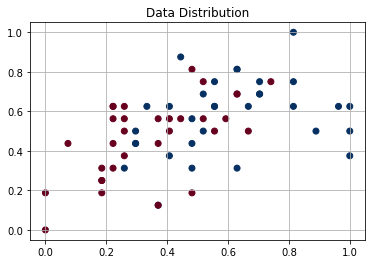

In [4]:
from classifiers.datasets.dataloader import Sklearn_DataLoader
from classifiers.datasets.datascaler import DataScaler
dl = Sklearn_DataLoader(labels=(1, 2))
X, y, _, _ = dl(2**6, true_hot=0)
X = X[:,:]
ds = DataScaler('minmax')
X = ds(X)
Plot_Data(X, y).plot()

In [5]:
svm = BinarySVM(kernel=Kernel('Pauli'), C=100, k=10, mutation='REDUCED_primal_QASVM')
svm.fit(X, y)
Plot_SVM(svm).plot_boundary()

QiskitError: 'Invalid input data format for Statevector'

In [ ]:
plt.plot(svm.f(X)*y)

In [ ]:
var_form = RealAmplitudes(6, reps=5)
qasm_sim = QasmSimulator()
qasm_sim.set_options(device='GPU')
quantum_instance = QuantumInstance(backend=qasm_sim)
#quantum_instance = QuantumInstance(backend=QasmSimulator.from_backend(backend, method='statevector_gpu'), shots=2**13, basis_gates=backend.configuration().basis_gates, initial_layout=None, measurement_error_mitigation_cls=CompleteMeasFitter, optimization_level=3, seed_transpiler=0)
qasvm = QASVM(X, y, quantum_instance=quantum_instance, C=100, k=10, option='Bloch_sphere', var_form=var_form).dual
print(qasvm.second_order_circuit.depth())
qasvm.second_order_circuit.draw(fold=-1, idle_wires=False)

In [ ]:
from tqdm.notebook import tqdm
epochs = 2**10
last_avg = 2**7

writer = SummaryWriter()
optimizer = SPSA(qasvm)
optimizer.calibrate(epochs)

storage = CostParamStorage()
early_stopping = ParamsStopping(patiance=1, last_avg=last_avg, tol=5e-2)

for epoch in tqdm(range(epochs)):
    optimizer.step(epoch)
    storage(epoch, qasvm.cost_fn, qasvm.parameters, writer=writer)
    if early_stopping(qasvm.parameters, epoch):
        break

qasvm.parameters = early_stopping.best_params


In [ ]:
storage.plot_params()

In [ ]:
storage.plot()

In [ ]:
svm = BinarySVM(kernel=Kernel('SingleQubit'), C=None, k=10, mutation='REDUCED_QASVM')
svm.fit(X, y)
compare_svm_and_qasvm(svm=svm, qasvm=qasvm)

In [ ]:
svm.dual_objective_value

In [ ]:
qasvm.cost_fn(qasvm.parameters)

In [ ]:
qasvm.parameters

In [ ]:
Plot_SVM(svm).plot()

In [ ]:
svm = BinarySVM(kernel=Kernel('SingleQubit'), C=100, k=10, mutation='REDUCED_primal_QASVM')
svm.fit(X, y)

In [ ]:
qasvm.parameters

In [ ]:
qasvm.quantum_instance = QuantumInstance(backend=QasmSimulator(), shots=2**13)

In [ ]:
early_stopping.watch_list.mean(axis=0).to_dict()